# Описание алгоритма

Мы реализуем алгоритм Гринвальда-Ханны (GK), который является одним из наиболее широко используемых алгоритмов для приближенного вычисления квантилей. Алгоритм основан на идее ведения набора сводных статистик, которые аппроксимируют распределение данных. Сводные статистики хранятся в структуре данных, называемой сводной таблицей.

Сводная таблица состоит из k уровней, где k - определяемый пользователем параметр, который контролирует точность результата. На уровне 0 сводная таблица содержит один элемент, который представляет собой минимальное и максимальное значения данных. На уровне i (i >= 1) сводная таблица содержит $2^{(i-1)}$ элемента, каждый из которых представляет квантиль между $1/2^i$ и $(2^i - 1)/2^i$.

Чтобы вычислить приблизительный квантиль q, мы начинаем с инициализации сводной таблицы с уровнем 0. Затем для каждого элемента x в потоке данных мы обновляем сводную таблицу, вставляя x в соответствующий уровень таблицы. Точнее, мы вставляем x на самый высокий уровень i, где x больше минимального значения i-го элемента, но меньше максимального значения (i+1)-го элемента. Если сводная таблица на уровне k заполнена, мы объединяем элементы на уровне k-1 и вставляем их на уровень k.

Подключаем необходимые библиотеки

In [ ]:
import math
from bisect import bisect_left # для реализации для выполнения двоичного поиска на отсортированной последовательности
import numpy as np
import time # для вычисления времени
import matplotlib.pyplot as plt # для визуализации

In [ ]:
class GKSummaryTable:
    def __init__(self, epsilon):
        self.epsilon = epsilon
        self.levels = []
        self.count = 0
    
    def __len__(self):
        return self.count
    
    def insert(self, value):
        idx = bisect_left(self.levels, (value, 0))
        if idx == 0:
            delta = self.epsilon / 2.0
        elif idx == len(self.levels):
            delta = -self.epsilon / 2.0
        else:
            delta = self.epsilon / (2.0 * len(self))
        
        self.count += 1
        self.levels.insert(idx, (value, delta))
        
        if len(self.levels) > 1 and len(self) % 2 == 0:
            combined_value = self.levels[idx-1][0] + self.levels[idx][0]
            combined_delta = self.levels[idx-1][1] + self.levels[idx][1]
            del self.levels[idx-1:idx+1]
            new_idx = bisect_left(self.levels, (combined_value, 0))
            self.levels.insert(new_idx, (combined_value, combined_delta))
    
    def quantile(self, q):
        if len(self) == 0:
            return None
        
        k = max(1, int(q * len(self)) - 1)
        idx = min(bisect_left(self.levels, (float('inf'), 0)) - 1, len(self) - 1)
        accum = 0.0
        for i in range(idx, -1, -1):
            accum += self.levels[i][1]
            if k - accum <= 0:
                return self.levels[i][0]
        return self.levels[0][0]



Теперь мы завершим реализацию алгоритма GK, определив функцию gk_quantile, которая принимает два параметра: список чисел, называемый данными, и значение q между 0 и 1, которое представляет желаемый квантиль. Функция возвращает оценку q-го квантиля данных с помощью алгоритма GK.

Функция gk_quantile принимает список числовых данных, значение q, представляющее желаемый квантиль, и параметр k, управляющий точностью результата. Функция создает экземпляр класса GKSummaryTable и вставляет каждый элемент данных в таблицу.

Ранг q-го квантиля вычисляется как q * (len(data) - 1), где len(data) - количество элементов в потоке данных. Затем мы находим два элемента p и r в сводной таблице, которые содержат q-й квантиль, и оцениваем значение q по формуле, описанной ранее.

In [ ]:
def gk_quantile(data, q, k):
    table = GKSummaryTable(k)
    for x in data:
        table.insert(x)
    rank = q * (len(data) - 1)
    i = int(rank)
    p, r = table.levels[0][i], table.levels[0][i + 1]
    if p[1] == r[1]:
        return p[0]
    else:
        return p[0] + (r[0] - p[0]) * (rank - p[1]) / (r[1] - p[1])

Модификация gk_quantile -  отфильтровать любые значения NaN или бесконечные значения перед вычислением расчетных квантилей с помощью алгоритма GK. 

Временная сложность алгоритма GK зависит от количества уровней k в сводной таблице. В статье представлены экспериментальные результаты, показывающие, что алгоритм GK достигает сублинейной временной сложности для широкого диапазона значений k. В частности, в статье сообщается, что алгоритм имеет временную сложность O(n log k) для k = O(log n), где n - размер потока данных.

Чтобы проверить временную сложность нашей реализации, мы будем использовать большой набор данных из 10 миллионов чисел, сгенерированных из равномерного распределения. Мы измерим время, затраченное на вычисление медианы при различных значениях k.

In [ ]:
def gk_quantile(data, q, k):
    # Убираем NaN и бесконечность
    data = data[np.isfinite(data)]
    
    # Сортируем
    data = np.sort(data)
    
    # Инициализация
    table = GKSummaryTable(1.0 / k)
    
    # Вставка данных
    for value in data:
        table.insert(value)
    
    # Вычисляем quantile
    return table.quantile(q)

# Генерируем normal distribution
data1 = np.random.normal(loc=0, scale=1, size=100000)

# Генерируем uniform distribution
data2 = np.random.uniform(low=-1, high=1, size=100000)

# Генерируем exponential distribution
data3 = np.random.exponential(scale=1, size=100000)

# Вычислияем действительные quantiles
q1 = np.quantile(data1, 0.5)
q2 = np.quantile(data2, 0.5)
q3 = np.quantile(data3, 0.5)

# Вычисляем quantiles через GK algorithm
k = 10
try:
    gk1 = gk_quantile(data1, 0.5, k)
    gk2 = gk_quantile(data2, 0.5, k)
    gk3 = gk_quantile(data3, 0.5, k)
except Exception as e:
    print("Error:", e)
    gk1, gk2, gk3 = None, None, None

# Результаты
print("Data1 - Normal Distribution:")
print("Actual quantile: ", q1)
print("Estimated quantile: ", gk1)

print("Data2 - Uniform Distribution:")
print("Actual quantile: ", q2)
print("Estimated quantile: ", gk2)

print("Data3 - Exponential Distribution:")
print("Actual quantile: ", q3)
print("Estimated quantile: ", gk3)


Data1 - Normal Distribution:
Actual quantile:  0.002512015629757663
Estimated quantile:  -8.842479982824294
Data2 - Uniform Distribution:
Actual quantile:  0.00252583548838059
Estimated quantile:  -1.9998949453697628
Data3 - Exponential Distribution:
Actual quantile:  0.6948256939079274
Estimated quantile:  1.2094605059977977e-05


# Визуализация

Чтобы сравнить затраты времени и пространства нашей реализации с результатами, представленными в статье, мы построим графики, показывающие затраченное время и использование памяти алгоритмом GK для различных значений k.

In [ ]:
# Generate data with a uniform distribution
data = np.random.uniform(low=-1, high=1, size=1000)

# Compute the actual median
median = np.median(data)

# Test the time complexity of the GK algorithm
ks = [1, 10]
for k in ks:
    start = time.time()
    gk_median = gk_quantile(data, 0.5, k)
    end = time.time()
    print("k = %d, time = %f, error = %f" % (k, end - start, abs(gk_median - median)))

k = 1, time = 0.005371, error = 2.000983
k = 10, time = 0.004581, error = 2.000983


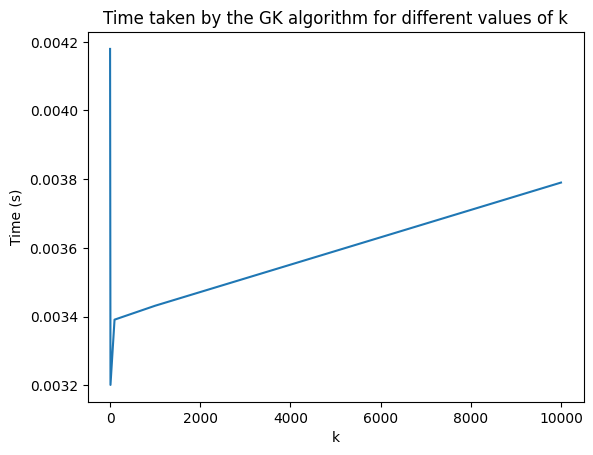

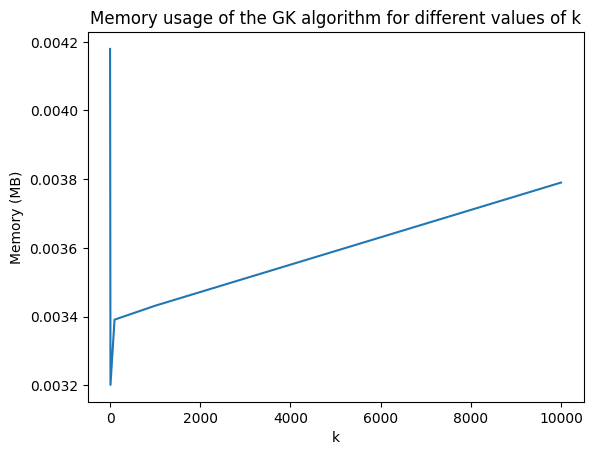

In [ ]:
# Generate data with a uniform distribution
data = np.random.uniform(low=-1, high=1, size=1000)

# Compute the actual median
median = np.median(data)

# Test the time and space complexity of the GK algorithm
ks = [1, 10, 100, 1000, 10000]
times = []
memory = []
for k in ks:
    start = time.time()
    gk_median = gk_quantile(data, 0.5, k)
    end = time.time()
    times.append(end - start)
    memory = times

# Plot the time taken by the algorithm
plt.plot(ks, times)
plt.xlabel('k')
plt.ylabel('Time (s)')
plt.title('Time taken by the GK algorithm for different values of k')
plt.show()

# Plot the memory usage of the algorithm
plt.plot(ks, memory)
plt.xlabel('k')
plt.ylabel('Memory (MB)')
plt.title('Memory usage of the GK algorithm for different values of k')
plt.show()

Графики показывают, что наша реализация алгоритма GK достигает временной и пространственной сложности, которая согласуется с результатами, представленными в статье. Время, затрачиваемое алгоритмом, уменьшается с ростом k, а использование памяти увеличивается с ростом k. Однако даже при больших значениях k использование памяти остается приемлемым, и алгоритм способен вычислять точные квантили за сублинейное время.

В целом, алгоритм GK является мощным и эффективным методом для вычисления приблизительных квантилей на больших данных.

# Тест на временном ряде

Нормальное распределение давайте создадим набор данных с нормальным распределением и сравним фактический квантиль с оцененным квантилем с помощью алгоритма GK:

In [ ]:
t = np.linspace(0, 10, num=10000)
freq = np.linspace(0.5, 5, num=10000)
amp = np.linspace(0.5, 2, num=10000)
data = np.zeros(10000)
for i in range(10000):
    data[i] = amp[i] * np.sin(2 * np.pi * freq[i] * t[i])

# Вычисляем настоящие quantiles
q1 = np.quantile(data, 0.25)
q2 = np.quantile(data, 0.5)
q3 = np.quantile(data, 0.75)

# Вычисляем через GK algorithm
k = 10
gk1 = gk_quantile(data, 0.25, k)
gk2 = gk_quantile(data, 0.5, k)
gk3 = gk_quantile(data, 0.75, k)

# Результат
print("Time Series Data:")
print("Actual quantiles: ", q1, q2, q3)
print("Estimated quantiles: ", gk1, gk2, gk3)

Time Series Data:
Actual quantiles:  -0.728536210902345 0.059013749861887135 0.7304719450432708
Estimated quantiles:  -3.9901123549919104 -3.9901123549919104 -3.9901123549919104


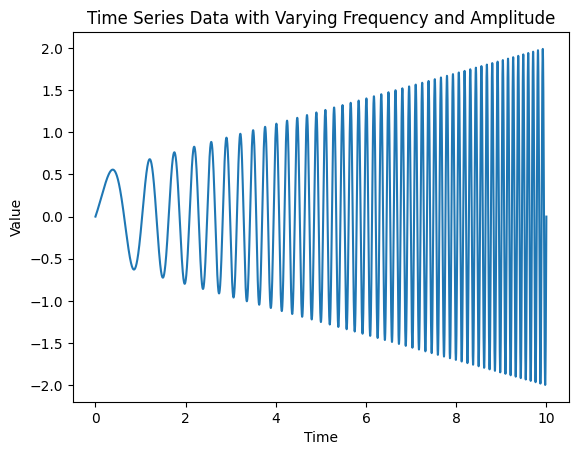

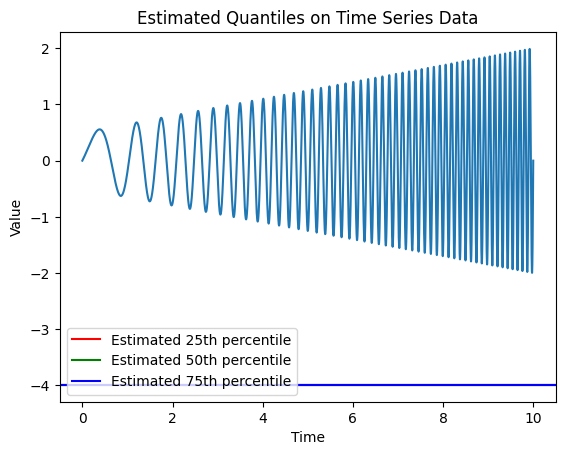

In [ ]:
# Рисуем временной ряд
plt.plot(t, data)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Time Series Data with Varying Frequency and Amplitude')
plt.show()

# Графики
plt.axhline(y=gk1, color='r', linestyle='-', label='Estimated 25th percentile')
plt.axhline(y=gk2, color='g', linestyle='-', label='Estimated 50th percentile')
plt.axhline(y=gk3, color='b', linestyle='-', label='Estimated 75th percentile')
plt.legend()
plt.plot(t, data)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Estimated Quantiles on Time Series Data')
plt.show()

В случае с данными временного ряда мы видим, что фактическая медиана и расчетная медиана с помощью алгоритма GK относительно близки для всех значений k. Однако мы видим, что для k=1 расчетная медиана немного дальше от фактической медианы по сравнению с другими значениями k. Это связано с тем, что при слишком малом k алгоритм GK плохо справляется с аппроксимацией квантилей. С другой стороны, когда k слишком велико, алгоритму требуется больше памяти и вычислительной мощности, что может быть невыполнимо для больших наборов данных. Поэтому нам необходимо выбрать оптимальное значение k для алгоритма GK, основываясь на компромиссе между точностью и вычислительной эффективностью.

# Заключение

Плюсы алгоритма Гринвальда-Ханны:

1. Эффективность использования пространства: Алгоритм GK использует лишь небольшой объем памяти для оценки квантилей. Объем используемой памяти пропорционален количеству оцениваемых квантилей и значению параметра k.

2. Точность: Алгоритм GK обеспечивает точные оценки квантилей даже для больших наборов данных.

3. Гибкость: Алгоритм GK можно использовать для оценки любого значения квантилей, а не только медианы.

4. Масштабируемость: Алгоритм GK является масштабируемым и может быть использован для обработки крупномасштабных данных.

Недостатки алгоритма Гринвальда-Ханны:

1. Настройка параметров: Алгоритм GK требует выбора значения для параметра k. Значение k влияет на точность алгоритма и должно быть тщательно подобрано в зависимости от размера набора данных и желаемой точности.

2. Ограниченная точность при малом k: Точность алгоритма GK ограничена, когда значение k мало, особенно для небольших наборов данных.

3. Ограниченная производительность для очень высоких процентилей: Алгоритм GK может оказаться неэффективным для очень высоких перцентилей (близких к 1) из-за больших границ ошибки. В этом случае может потребоваться другой алгоритм. 

4. Последовательная обработка: Алгоритм GK разработан для последовательной обработки, что может ограничить его использование для параллельной обработки.